In [1]:
from halohoops import haloHoops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [6]:
c = haloHoops(1, w=True)
c.get_data()

Data Loaded successfully.
Generating training data frame.
Generating test data frame.


# Regular Season Data

In [7]:
c.df_train.head()

,Season,TeamID_1,TeamID_2,Result,t1_seed,t1_Wavg,t1_margin,t2_seed,t2_Wavg,t2_margin
0,2003,3130,3330,1,5,0.714286,10.821429,12,0.677419,8.483871
1,2003,3160,3140,1,6,0.758621,8.413793,11,0.633333,6.466667
2,2003,3208,3150,1,5,0.678571,12.928571,12,0.724138,7.034483
3,2003,3261,3402,1,1,0.900000,18.500000,16,0.580645,-0.161290
4,2003,3278,3408,1,6,0.821429,14.000000,11,0.678571,8.821429


In [10]:
c.test_data.head()

,ID,Season,t1_id,t2_id,t1_kpom,t2_kpom,t1_seed,t2_seed,MaxWeek,t1_Wavg,t1_margin,t2_Wavg,t2_margin
0,2016_1112_1114,2016,1112,1114,16,47,6,12,133,0.757576,12.212121,0.870968,9.935484
1,2016_1112_1122,2016,1112,1122,16,211,6,16,133,0.757576,12.212121,0.484848,-2.363636
2,2016_1112_1124,2016,1112,1124,16,24,6,5,133,0.757576,12.212121,0.656250,6.687500
3,2016_1112_1138,2016,1112,1138,16,130,6,14,133,0.757576,12.212121,0.575758,0.666667
4,2016_1112_1139,2016,1112,1139,16,40,6,9,133,0.757576,12.212121,0.677419,9.419355


In [15]:
m = LogisticRegression()
m.fit(X,y)

,Season,TeamID_1,TeamID_2,Result,MaxWeek,t1_kpom,t2_kpom,t1_seed,t2_seed,t1_Wavg
0,2003,1421,1411,1,133,273,268,16,16,0.448276
1,2003,1112,1436,1,133,3,144,1,16,0.892857
2,2003,1113,1272,1,133,32,20,10,7,0.620690
3,2003,1141,1166,1,133,50,27,11,6,0.793103
4,2003,1143,1301,1,133,40,48,8,9,0.724138


In [8]:
c.train_model()

Baseline logistic model trained, predictions made...
Baseline log-loss score of 0.56336


In [9]:
c.create_sub('logistic_added_feat1.csv')

(array([1503., 1231.,  968.,  769.,  800.,  758.,  738.,  866., 1024.,
        1423.]),
 array([0.00148799, 0.10120889, 0.20092979, 0.30065069, 0.40037159,
        0.50009249, 0.59981339, 0.69953429, 0.79925519, 0.89897608,
        0.99869698]),
 <BarContainer object of 10 artists>)

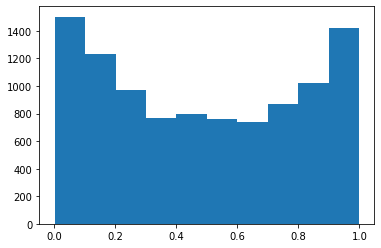

In [10]:
plt.hist(c.test_preds[:,1])

In [26]:
# get probs for test set
# calc score for baseline and test set probs
X_test = c.test_data[['Season', 't1_kpom', 't2_kpom', 't1_seed', 't2_seed']]

lr_full = LogisticRegression()
lr_full.fit(X, y)
test_preds = lr_full.predict_proba(X_test)

print("Baseline logistic model trained, predictions made...")
print("Baseline log-loss score of {}".format(0.56336))
c.submission['Pred'] = test_preds[:,1]
c.submission.to_csv('./submissions/base_logistic_regression.csv', index=False)

Baseline logistic model trained, predictions made...
Baseline log-loss score of 0.5


In [23]:
c.test_data.head()

,ID,Season,t1_id,t2_id,t1_kpom,t2_kpom,t1_seed,t2_seed,MaxWeek
0,2016_1112_1114,2016,1112,1114,16,47,6,12,133
1,2016_1112_1122,2016,1112,1122,16,211,6,16,133
2,2016_1112_1124,2016,1112,1124,16,24,6,5,133
3,2016_1112_1138,2016,1112,1138,16,130,6,14,133
4,2016_1112_1139,2016,1112,1139,16,40,6,9,133


In [5]:
ords = c.data['ordinals']
m1 = ords['Season'] == 2016
m2 = ords['RankingDayNum'] == 133
m3 = ords['SystemName'] == 'POM'
m4 = ords['TeamID'] == 1139
ords.loc[m1&m2&m3&m4]

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
2877880,2016,133,POM,1139,40


In [9]:
M = haloHoops(1)
M.get_data()
X = M.df_train[['Season', 't1_kpom', 't2_kpom', 't1_seed', 't2_seed']]
y = M.df_train[['Result']]

tune_params = {
    'min_child_weight': [1,5,10,25,100],
    'gamma': [0.1, 0.5, 1, 2, 5],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5,0.75,1.0],
    'max_depth': [1,2,5,10,20,50],
    'learning_rate': [0.01,0.05,0.1,0.15,0.2],
    'n_estimators': [2,5,10,20,50,100,200,500]
}

xgCV = XGBClassifier(silent=True, nthread=1)

folds = 5
param_comb=8

random_search = RandomizedSearchCV(xgCV, param_distributions = tune_params, n_iter = param_comb, scoring = 'neg_log_loss', n_jobs=4, verbose=3)

random_search.fit(X, y)

Data Loaded successfully.
Generating training data frame.
Generating test data frame.
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[22:54:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   14.3s finished
C:\Users\Gutwein\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gutwein\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...one, silent=True, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid=True, n_iter=8, n_jobs=4,
          param_distributions={'subsample': [0.5, 0.75, 1], 'max_depth': [1, 2, 5, 10, 20, 50], 'colsample_bytree': [0.5, 0.75, 1.0], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'gamma': [0.1, 0.5, 1, 2, 5], 'n_estimators': [2, 5, 10, 20, 50, 100, 200, 500], 'min_child_weight': [1, 5, 10, 25, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=3)

In [10]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.05, max_delta_step=0, max_depth=50,
       min_child_weight=25, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.75,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y)
Mxgb = random_search.best_estimator_
Mxgb.fit(X_train, y_train)
preds = Mxgb.predict_proba(X_dev)
log_loss(y_dev, preds[:,1])

[22:58:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Gutwein\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gutwein\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5485518794541933

In [12]:
Mxgb.feature_importances_

array([0.05780034, 0.23822483, 0.16222268, 0.24814588, 0.29360625],
      dtype=float32)